## Analysis of acoustic signals - plain code

<img src="figures_blog/sliding_lid.png" width=500>

In [13]:
from acoustics import generalized_detrending, sorted_density, sorted_density_feature, gaussian_sorted_density
from acoustics_helpers import remove_direct_sound, curve_fitting_echo_density

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

In [15]:
with h5py.File('data.h5', 'r') as hf:
    Fs_array = list(hf['Fs'])
    dataset_simulation_polybox = list(hf['dataset_simulation_polybox'])
    dataset_simulation_sliding_lid = list(hf['dataset_simulation_sliding_lid'])

In [16]:
Fs = Fs_array[1]

In [17]:
# ws stands for window size
ws_detrending = int(0.025*Fs)     # 25ms
ws_sorted_density = int(0.2*Fs)   # 200ms
signal_length = 1

We need the Gaussian measure of detrended sorted density, since the reverberation of the room has close to Gaussian behavior. This constant will be used for the normalization before the curve fitting.

In [18]:
gaussian_sd = gaussian_sorted_density(ws_detrending)
print('Sorted density for Gaussian signal: ', gaussian_sd)

Sorted density for Gaussian signal:  0.18377228132362045


In [19]:
labels = ['closed', 'almost_closed', 'almost_open', 'open']

In [20]:
from collections import defaultdict
data = defaultdict()
for i in range(len(labels)):
    data[labels[i]] = dataset_simulation_sliding_lid[i]
data_simulation_sliding_lid = pd.DataFrame(data = data, index = pd.timedelta_range(start=pd.Timedelta(days=0), 
                                                                                         freq=str(round(1000/Fs, 5)) + 'ms', 
                                                                                         periods=len(dataset_simulation_sliding_lid[0])))
data_simulation_sliding_lid.head()

,almost_closed,almost_open,closed,open
00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
00:00:00.000170,4.372601e-07,4.443116e-07,4.443116e-07,4.456350e-07
00:00:00.000340,1.283440e-05,1.300656e-05,1.300656e-05,1.303693e-05
00:00:00.000510,4.311583e-05,4.364509e-05,4.364509e-05,4.377377e-05
00:00:00.000680,1.957845e-05,1.987153e-05,1.987153e-05,1.991281e-05


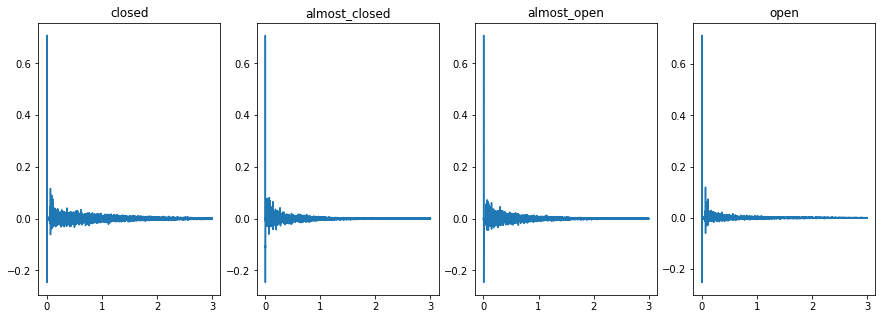

In [21]:
t = np.array(range(data_simulation_sliding_lid.shape[0]))/Fs
fig, ax = plt.subplots(1,4,figsize=(15,5))
for i in range(len(labels)):
    ax[i].plot(t, data_simulation_sliding_lid[labels[i]])
    ax[i].set_title(labels[i])

c:\users\helena\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


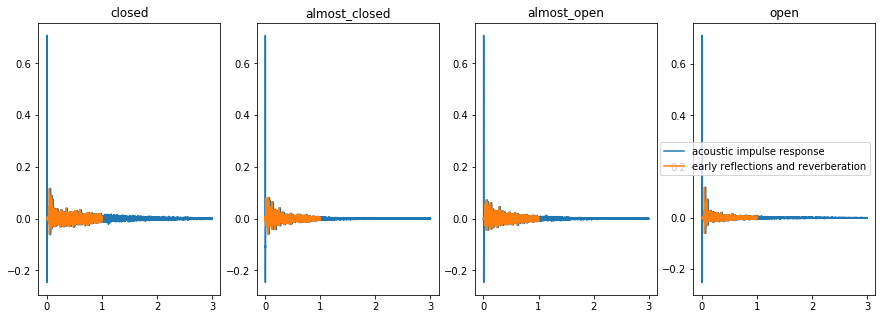

In [22]:
data_dir = defaultdict()
fig, ax = plt.subplots(1,4,figsize=(15,5))
for i in range(len(labels)):
    signal = data_simulation_sliding_lid[labels[i]]
    ax[i].plot(t[:len(signal)], signal, label='acoustic impulse response')
    data_dir[labels[i]] = remove_direct_sound(signal, Fs, signal_length)
    ax[i].plot(t[:len(data_dir[labels[i]])], data_dir[labels[i]], label='early reflections and reverberation')
    ax[i].set_title(labels[i])
plt.legend()

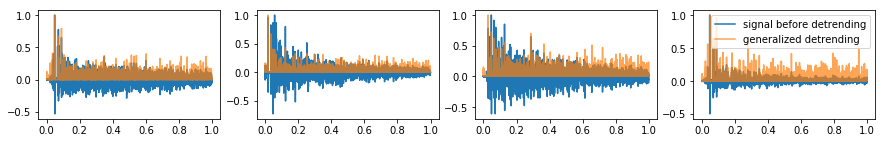

In [23]:
data_dtr = defaultdict()
fig, ax = plt.subplots(1,4,figsize=(15,2))
for i in range(len(labels)):
    signal = data_dir[labels[i]]
    ax[i].plot(t[:len(signal)], signal/np.max(np.abs(signal)), alpha=1, label='signal before detrending')
    data_dtr[labels[i]] = generalized_detrending(signal.to_numpy(), ws_detrending)
    ax[i].plot(t[:len(data_dtr[labels[i]])], data_dtr[labels[i]]/np.max(np.abs(data_dtr[labels[i]])), alpha=0.7, label='generalized detrending')
plt.legend()

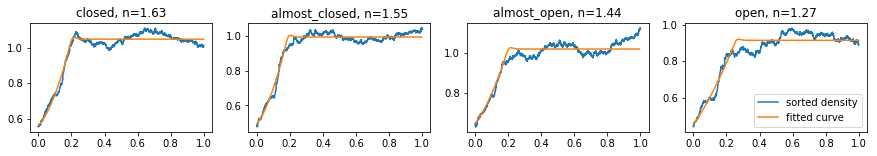

In [24]:
data_srt = defaultdict()
fig, ax = plt.subplots(1,4,figsize=(15,2))
for i in range(len(labels)):
    signal = data_dtr[labels[i]]
    data_srt[labels[i]] = sorted_density_feature(signal, ws_sorted_density)
    data_srt[labels[i]] = data_srt[labels[i]]/gaussian_sd
    n, curve = curve_fitting_echo_density(data_srt[labels[i]], Fs)
    ax[i].plot(t[:len(data_srt[labels[i]])], data_srt[labels[i]], label = 'sorted density')
    ax[i].plot(t[:len(curve)], curve, label = 'fitted curve')
    ax[i].set_title(labels[i] + ', n=' + '{0:.2f}'.format(n))
plt.legend()